# Training The Miniplaces Dataset with ResNet50

[The miniplaces dataset ](http://6.869.csail.mit.edu/fa17/miniplaces.html) is a subsample of the the [Places2 dataset](http://places2.csail.mit.edu/) (which consists of 10+ million images of palces) consisting of 100,000 images for training, 10,000 images for validation and 10,000 images for testing coming from 100 scene categories. The images are resized to `128*128` to make the data more manageable.


<img src='https://github.com/CSAILVision/miniplaces/blob/master/teaser.jpg?raw=true'>miniplaces</img>

## Setup the environment

In [1]:
import torch
import torchvision
import torchvision.datasets.utils as utils
from sklearn.model_selection import train_test_split

import os
from pathlib import Path
import shutil

## Download and prepare the datasset.

The [MiniPlaces Dataset](https://github.com/CSAILVision/miniplaces) employs the [ImageFolder](https://pytorch.org/vision/main/generated/torchvision.datasets.ImageFolder.html) structure.

-- miniplaces

---- train (1000 images per 100 places)

--------place1

----------image001

----------image002

--------place2

----------image001

----------image002

.

.

-----val

--------place1

----------image001

----------image002

--------place2

----------image001

----------image002

.

.

----test

--------place1

----------image001

----------image002

--------place2

----------image001

----------image002



In [2]:
%%capture

!wget https://dissect.csail.mit.edu/datasets/miniplaces.zip --no-check-certificate && unzip miniplaces.zip

In [3]:
print(f"Total images for validation is: {sum(f.is_file() for f in Path('miniplaces/val').rglob('*'))}\
    \nThis will be split in 70:30 ratio for validation and testing.")

Total images for validation is: 10000    
This will be split in 70:30 ratio for validation and testing.


In [4]:
# utils.download_and_extract_archive('http://dissect.csail.mit.edu/datasets')

# set the path
dataset_path = Path('miniplaces')

val_path = Path('miniplaces/val')

# get classes list
place_names = [dir.name for dir in val_path.iterdir() if dir.is_dir()]

# create test directory
test_path = dataset_path / 'test'
test_path.mkdir(exist_ok=True)

# Now we move some images (30%) from the val folder to test folder
# Iterate over each class
for place in place_names:
    # create place names sub-directories as in val directory to be moved into test directory
    place_dir = val_path.joinpath(place)
    place_images = [image.name for image in place_dir.iterdir() if image.is_file()] # store each image in class_dir in classfiles

    # split the validation set per place folder
    val_images, test_images = train_test_split(place_images, test_size=0.3, random_state=42)

    # create new class directories in test_path
    test_places_dir = test_path.joinpath(place)
    test_places_dir.mkdir(exist_ok=True)

    # move the test file from validation folder to test folder
    for test_image in test_images:
        source = place_dir / test_image
        destination = test_places_dir / test_image
        shutil.move(source, destination)


## Data Augmentation and transformation with Dataset and Dataloader

 - Datasets: Pytorch collection of data
 - ImageFolder: allows to load images directly from the directory structure
 - DataLoader: provides an efficient way to iterate the images during training. Implements the `__get__()` and `__length__()` methods.



__loading structure__: `transform --> datasets.ImageFolder --> DataLoader`

In [5]:
from torch.utils.data.dataloader import DataLoader
from torchvision import datasets, transforms
from torchvision.datasets import ImageFolder

input_size = 128
batch_size = 320
# Define transformations
train_transform = transforms.Compose([
    transforms.Resize(input_size), # enusre 128*128
    transforms.RandomHorizontalFlip(),  # Additional data augmentation
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Additional augmentation
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
])

test_transform = transforms.Compose([
    transforms.Resize(input_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
])

# Define datasets
train_dataset = ImageFolder(dataset_path / 'train', transform=train_transform)
val_dataset = ImageFolder(val_path, transform=test_transform)
test_dataset = ImageFolder(test_path, transform=test_transform)

# Define data loaders with increased num_workers for faster data loading
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)



# train_dataloader, val_dataloader, test_dataloader = preprocess_data(train_data_path=dataset_path / 'train',
#                                                                     val_data_path=dataset_path / 'val',
#                                                                     test_data_path=dataset_path / 'test')

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [6]:
len(train_dataloader)

313

### get a list of all files in all classes

In [7]:
with open('miniplaces/train.txt') as f:
    files_in_class = [file.strip() for file in f.readlines()]

### Display randomly sampled images

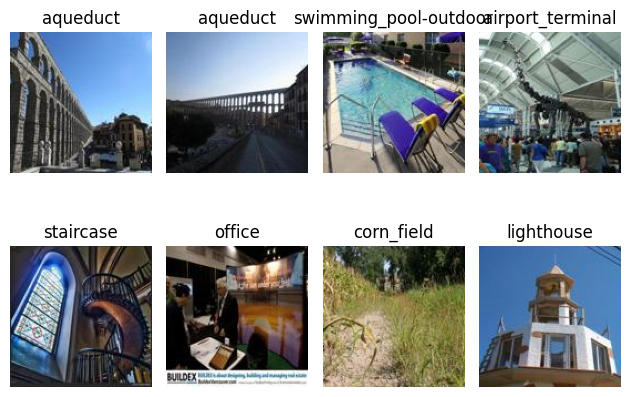

In [8]:
import matplotlib.pyplot as plt
from PIL import Image
import random


def display_rand_img(n: int):

    random_images = random.sample(range(len(files_in_class)), k=n)

    fig, axes = plt.subplots(2, n//2, sharex=True, sharey=True)

    for i, ax in enumerate(axes.flat):
        sample = random_images[i]
        img_path = os.path.join('miniplaces',files_in_class[sample])

        img = Image.open(img_path)
        ax.imshow(img)
        ax.set_title(Path(img_path).parent.stem)
        ax.set_axis_off()

    plt.tight_layout()
    plt.show()

display_rand_img(8)

## Instantiate a Pretrained Model

In [9]:
from torchvision.models import resnet50, ResNet50_Weights

# fetch the pretrained resnet50 model
model = resnet50(weights=ResNet50_Weights.DEFAULT)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 173MB/s]


In [10]:
import torch.nn as nn

# modify the last layer
num_features = model.fc.in_features # number of input features of the resnet50
num_classes = len(place_names)
model.fc = nn.Linear(in_features=num_features, out_features=num_classes) # createe new output layer with same in_features

## Define Loss Fxn and Optimizer

In [11]:
import torch.nn as nn
import torch.optim as optim

# Loss Function
criterion = nn.CrossEntropyLoss() # combines the softmax activation + neg log likehood loss

# optimizer
optimizer = optim.Adam(model.parameters(), lr=5e-4, weight_decay=0.0001)


## Create Checkpoint

In [12]:
def save_checkpoint(model, optimizer, epoch, loss, filepath):
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss,
    }
    torch.save(checkpoint, filepath)

## Training Loop

In [13]:
import time

start_time = time.time()
checkpoint_interval = 30


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Training on device: {device}')

# move model to GPU
if torch.cuda.device_count() > 1:
    print(f'Using {torch.cuda.device_count()} GPUs for training.')
    model = nn.DataParallel(model)

# Move model to the available device(s)
# model = model.to(device)
model = model.to(device)

# to store losses and accuracies
train_losses = []
train_accuraces = []

epochs = 50
now = 0

# training
for epoch in range(epochs):
    total_losses = 0
    correct = 0
    total = 0

    # set model to training mode
    model.train()

    # iterate over the dataset
    for images, labels in train_dataloader:
        images = images.to(device)
        labels = labels.to(device)

        # reset the gradients
        optimizer.zero_grad()

        # forward pass
        outputs = model(images)

        # calculate loss
        loss = criterion(outputs, labels)

        # backward pass
        loss.backward()

        # update parameters
        optimizer.step()

        # cummulate metrics
        total_losses += loss.item() # loss returns a scalar tensor so use item() method to get the scalar
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    # calculate average metrics
    average_loss = total_losses / len(train_dataloader)
    accuracy = 100.0 * correct / total

    train_losses.append(average_loss)
    train_accuraces.append(accuracy)

    # Print training metrics for the current epoch
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {average_loss:.4f}, Accuracy: {accuracy:.2f}%, t-{(time.time()-start_time):.0f}s")

    # Check if it's time to create a checkpoint
    if time.time() - start_time > checkpoint_interval:
        if epoch % 5 == 0:
            torch.save(model.state_dict(), f'checkpoint_epoch.pth_{epoch}')  # Save the model
    start_time = time.time()  # Reset start time

Training on device: cuda
Epoch [1/50], Loss: 2.0170, Accuracy: 46.88%, t-332s
Epoch [2/50], Loss: 1.4628, Accuracy: 58.91%, t-328s
Epoch [3/50], Loss: 1.2768, Accuracy: 63.28%, t-327s
Epoch [4/50], Loss: 1.1332, Accuracy: 66.76%, t-327s
Epoch [5/50], Loss: 1.0287, Accuracy: 69.36%, t-329s
Epoch [6/50], Loss: 0.9299, Accuracy: 71.85%, t-325s
Epoch [7/50], Loss: 0.8450, Accuracy: 74.31%, t-328s
Epoch [8/50], Loss: 0.7664, Accuracy: 76.37%, t-329s
Epoch [9/50], Loss: 0.7047, Accuracy: 77.98%, t-329s
Epoch [10/50], Loss: 0.6410, Accuracy: 79.99%, t-327s
Epoch [11/50], Loss: 0.5851, Accuracy: 81.58%, t-328s
Epoch [12/50], Loss: 0.5377, Accuracy: 83.06%, t-327s
Epoch [13/50], Loss: 0.5011, Accuracy: 84.21%, t-328s
Epoch [14/50], Loss: 0.4719, Accuracy: 84.98%, t-328s
Epoch [15/50], Loss: 0.4369, Accuracy: 86.26%, t-327s
Epoch [16/50], Loss: 0.4025, Accuracy: 87.14%, t-328s
Epoch [17/50], Loss: 0.3911, Accuracy: 87.45%, t-330s
Epoch [18/50], Loss: 0.3667, Accuracy: 88.42%, t-329s
Epoch [19/50

## Visualize Training performance

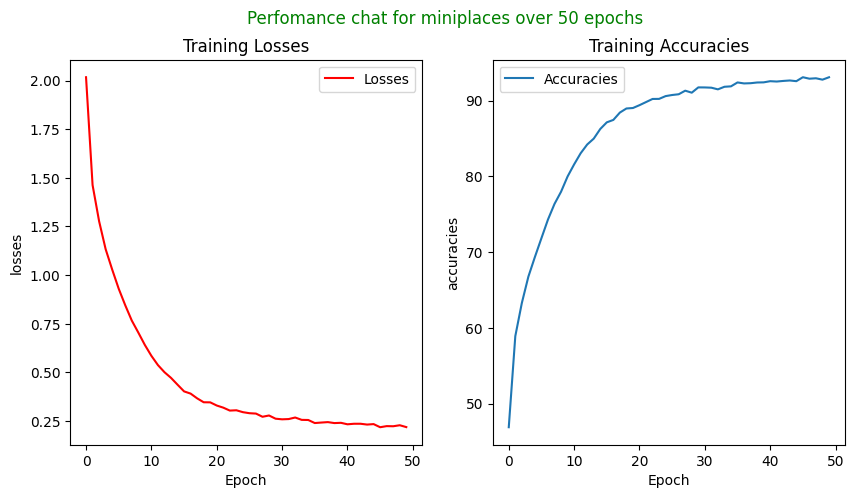

In [14]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

ax1.plot(train_losses, label='Losses', c='r')
ax1.set(title='Training Losses',
       xlabel='Epoch',
       ylabel='losses')
ax1.legend()


ax2.plot(train_accuraces, label='Accuracies')
ax2.set(title='Training Accuracies',
       xlabel='Epoch',
       ylabel='accuracies')
ax2.legend()

fig.suptitle(f'Perfomance chat for miniplaces over {epochs} epochs\n', fontdict={'color': 'g'})
plt.show()

## Testing and Evaluation

In [15]:
def evaluate_model(model, dataloader):
    model.eval() # evaluation mode

    # initialize counters
    total = 0
    correct = 0
    true_positives = 0
    predicted_positives = 0
    actual_positives = 0

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device) # move images to targeted device
            labels = labels.to(device) # move labels to targeted device

            outputs = model(images) # predict labels
            _, predicted = outputs.max(1)
            loss = criterion(outputs, predicted).item()

            # count the true positives, predicted positives, and actual positives
            true_positives += torch.logical_and(predicted==1, labels==1).sum().item() #
            predicted_positives += (predicted == 1).sum().item()
            actual_positives += (labels == 1).sum().item()

            # calculate metrics
            total += labels.size(0) # total number of samples
            accuracy = 100.0 * torch.sum(predicted == labels) / total # accuracy = correct / total
            precision = true_positives / predicted_positives # precision = TP / (TP + FP)
            recall = true_positives / actual_positives # recall = TP / (TP + FN)

            return accuracy, precision, recall

accuracy, precision, recall = evaluate_model(model, val_dataloader)

print(f"Test Accuracy: {accuracy:.2f}%")
print(f"Test Precision: {precision:.2f}")
print(f"Test Recall: {recall:.2f}")

Test Accuracy: 62.19%
Test Precision: 0.98
Test Recall: 0.66


Predicted class: amusement_park | Probability: 0.95


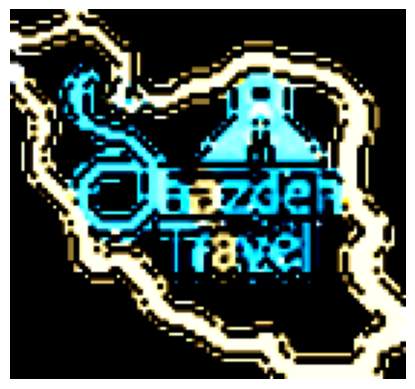

Predicted class: dam | Probability: 0.13


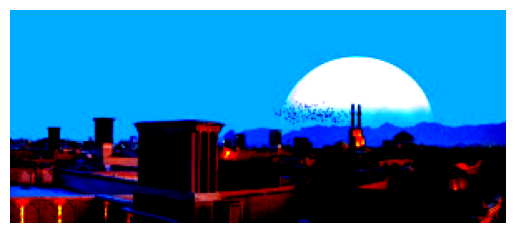

Predicted class: courtyard | Probability: 0.94


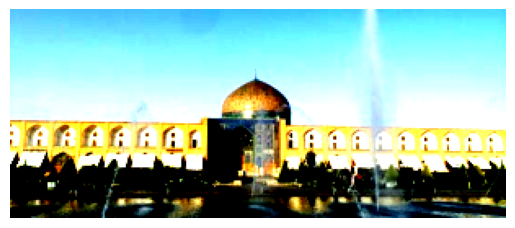

Predicted class: canyon | Probability: 0.94


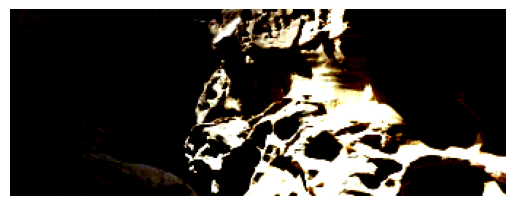

Predicted class: mountain | Probability: 0.38


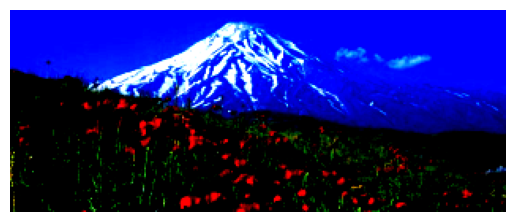

Predicted class: courtyard | Probability: 0.55


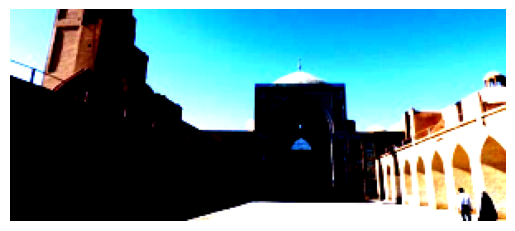

Predicted class: cemetery | Probability: 0.74


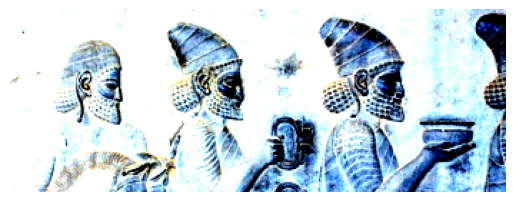

Predicted class: desert-sand | Probability: 0.93


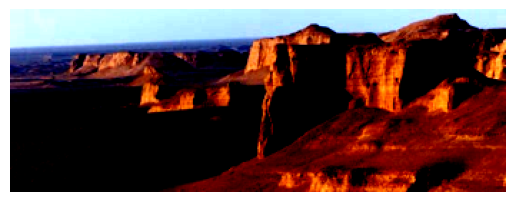

Predicted class: skyscraper | Probability: 0.64


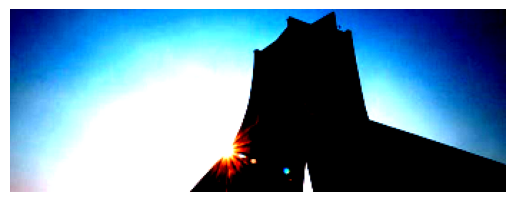

Predicted class: desert-sand | Probability: 0.91


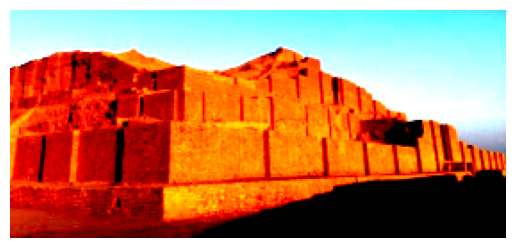

Predicted class: palace | Probability: 0.63


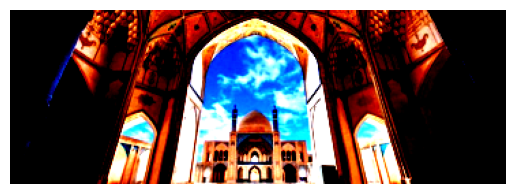

Predicted class: hot_spring | Probability: 0.56


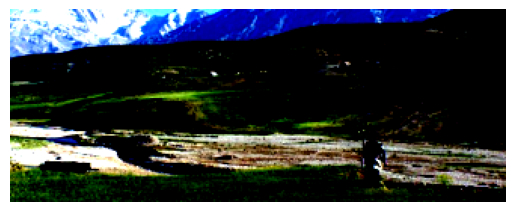

In [18]:
import warnings
warnings.simplefilter('ignore')

from PIL import Image
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup

# Load and process the new image

url = 'https://www.shazdeh-travel.com/iran-travel-guide-2024/best-places-to-visit-in-iran'
response = requests.get(url)

soup = BeautifulSoup(response.content, 'lxml')

images = [img.get('src') for img in soup.find_all('img') if img.get('src') is not None]

# fig, axes = plt.subplots(nrows=3, ncols=len(images)//3)

# ax = axes.flat

for i, image in enumerate(images):
    with open('unknown.img', 'wb') as f:
      f.write(requests.get(image).content)

    image_path = 'unknown.img' #'/kaggle/working/miniplaces/val/bamboo_forest/00006502.jpg'#"/kaggle/working/miniplaces/test/lighthouse/00000669.jpg"
    image = Image.open(image_path).convert("RGB")

    # transform new image
    transform = transforms.Compose([transforms.Resize(input_size),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))])
    input_image = transform(image).unsqueeze(0).to(device)

#   set model to eval mode
    model.eval()

    with torch.no_grad():
        outputs = model(input_image)
        _, predicted = outputs.max(1)

        probs = nn.functional.softmax(outputs, 1)[0]

        # get predicted class probs
        class_label = predicted.item()
        class_prob = probs[class_label].item()

        print(f"Predicted class: {test_dataloader.dataset.classes[class_label]} | Probability: {class_prob:.2f}")

        plt.imshow(input_image.squeeze().permute(1,2,0).to('cpu'))
        plt.axis('off')
        plt.show()
        print()

## Save model

In [32]:
from joblib import dump, load

dump(model,filename='miniplaces.gz')

torch.save(model.state_dict(), 'miniplaces_state_dict.pth')

In [42]:
input_shape = next(iter(train_dataloader))[0].shape

In [56]:
loaded = torch.load('miniplaces_state_dict.pth')



new_model = resnet50(pretrained=False)

new_model.fc = nn.Linear(new_model.fc.in_features, 100)

new_model.load_state_dict(loaded)

new_model.state_dict().keys()

odict_keys(['conv1.weight', 'bn1.weight', 'bn1.bias', 'bn1.running_mean', 'bn1.running_var', 'bn1.num_batches_tracked', 'layer1.0.conv1.weight', 'layer1.0.bn1.weight', 'layer1.0.bn1.bias', 'layer1.0.bn1.running_mean', 'layer1.0.bn1.running_var', 'layer1.0.bn1.num_batches_tracked', 'layer1.0.conv2.weight', 'layer1.0.bn2.weight', 'layer1.0.bn2.bias', 'layer1.0.bn2.running_mean', 'layer1.0.bn2.running_var', 'layer1.0.bn2.num_batches_tracked', 'layer1.0.conv3.weight', 'layer1.0.bn3.weight', 'layer1.0.bn3.bias', 'layer1.0.bn3.running_mean', 'layer1.0.bn3.running_var', 'layer1.0.bn3.num_batches_tracked', 'layer1.0.downsample.0.weight', 'layer1.0.downsample.1.weight', 'layer1.0.downsample.1.bias', 'layer1.0.downsample.1.running_mean', 'layer1.0.downsample.1.running_var', 'layer1.0.downsample.1.num_batches_tracked', 'layer1.1.conv1.weight', 'layer1.1.bn1.weight', 'layer1.1.bn1.bias', 'layer1.1.bn1.running_mean', 'layer1.1.bn1.running_var', 'layer1.1.bn1.num_batches_tracked', 'layer1.1.conv2.we